# Data Exploration for XAI Analysis

**Purpose**: Basic exploratory data analysis for thesis appendix.

This notebook provides descriptive statistics and distributions for:
- Target variable (default rates)
- Feature distributions (histograms, summary statistics)
- Temporal patterns (defaults over time)
- Missing data patterns

**Outputs**: Tables and figures for thesis appendix.

In [8]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import FEATURE_CACHE_PATH
from credit_risk_xai.features.engineer import prepare_modeling_data

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print(f"Project root: {PROJ_ROOT}")

Project root: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis


## 1. Load Data

In [9]:
# Load full dataset
df_full = pd.read_parquet(FEATURE_CACHE_PATH)
print(f"Full dataset: {len(df_full):,} observations")
print(f"Columns: {len(df_full.columns)}")
print(f"\nDate range: {df_full['ser_year'].min()} - {df_full['ser_year'].max()}")

Full dataset: 12,473,668 observations
Columns: 76

Date range: 1998 - 2023


In [10]:
# Apply same filters as modeling
df = df_full[
    (df_full["ser_aktiv"] == 1) & 
    (df_full["sme_category"].isin(["Small", "Medium"])) & 
    (df_full["knc_kncfall"] == 1) &
    (df_full["bransch_borsbransch_konv"] != "40.0")
].copy()

print(f"\nFiltered dataset: {len(df):,} observations ({len(df)/len(df_full)*100:.1f}% of full data)")
print(f"Filters applied:")
print(f"  - Active companies (ser_aktiv==1)")
print(f"  - Small & Medium SMEs")
print(f"  - Credit reporting companies (knc_kncfall==1)")
print(f"  - Excluded industry: 40.0 (Financial services)")


Filtered dataset: 329,492 observations (2.6% of full data)
Filters applied:
  - Active companies (ser_aktiv==1)
  - Small & Medium SMEs
  - Credit reporting companies (knc_kncfall==1)
  - Excluded industry: 40.0 (Financial services)


## 2. Target Variable Analysis

In [11]:
# Prepare modeling data
X, y = prepare_modeling_data(df)

print("="*80)
print("TARGET VARIABLE: target_next_year (Default within 12 months)")
print("="*80)
print(f"\nTotal observations: {len(y):,}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nDefault rate: {y.mean()*100:.2f}%")
print(f"Imbalance ratio: {(y==0).sum()/(y==1).sum():.1f}:1")

TARGET VARIABLE: target_next_year (Default within 12 months)

Total observations: 306,985

Class distribution:
target_next_year
0    300486
1      6499
Name: count, dtype: Int64

Default rate: 2.12%
Imbalance ratio: 46.2:1


In [12]:
# Default rate over time
df_with_target = df.copy()
df_with_target['target_next_year'] = y

default_rate_by_year = df_with_target.groupby('ser_year').agg({
    'target_next_year': ['sum', 'count', 'mean']
}).reset_index()
default_rate_by_year.columns = ['ser_year', 'n_defaults', 'n_total', 'default_rate']

print("\nDefault Rate by Year:")
print("="*80)
print(default_rate_by_year.to_string(index=False))


Default Rate by Year:
 ser_year  n_defaults  n_total  default_rate
     1998         129    10467      0.012324
     1999         197    11053      0.017823
     2000         252    11360      0.022183
     2001         297    11546      0.025723
     2002         318    11516      0.027614
     2003         269    11168      0.024087
     2004         228    10987      0.020752
     2005         169    11064      0.015275
     2006         167    11581       0.01442
     2007         254    12429      0.020436
     2008         359    12478      0.028771
     2009         275    11940      0.023032
     2010         244    12101      0.020164
     2011         253    12259      0.020638
     2012         279    12075      0.023106
     2013         256    11878      0.021552
     2014         217    11782      0.018418
     2015         229    12072       0.01897
     2016         237    12485      0.018983
     2017         267    12622      0.021154
     2018         284    12791  

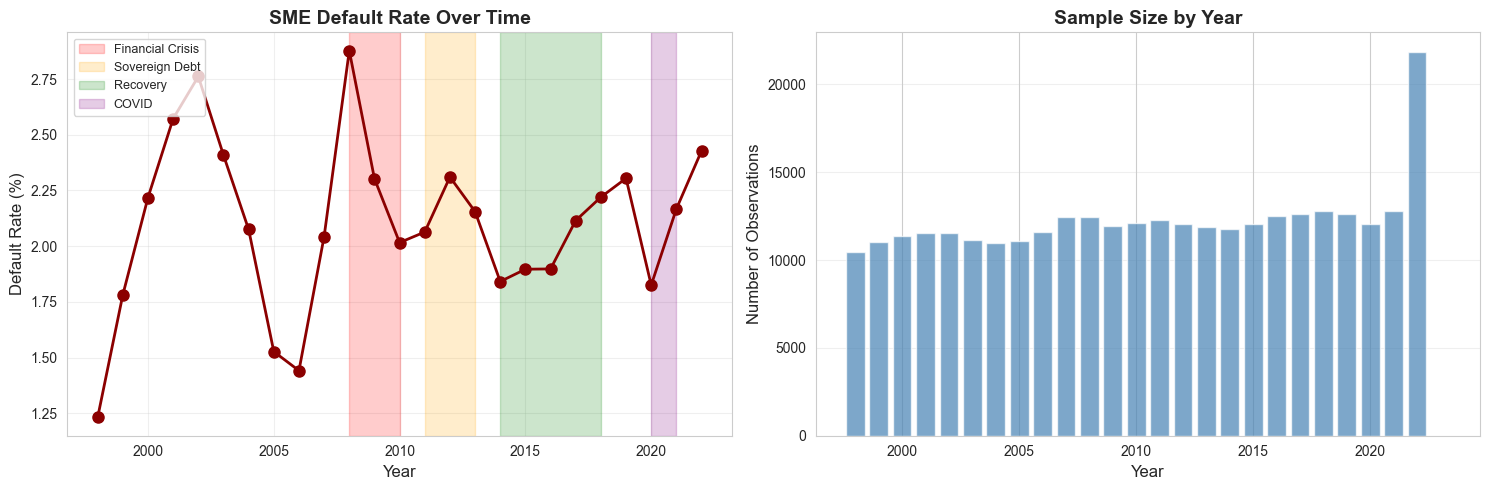


Note: Economic regimes used in temporal analysis:
  • Financial Crisis: 2008-2010
  • Sovereign Debt Crisis: 2011-2013
  • Recovery: 2014-2018
  • COVID: 2020-2021
  • Post-COVID: 2022-2023


In [13]:
# Visualize default rate over time
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Default rate trend
axes[0].plot(default_rate_by_year['ser_year'], 
             default_rate_by_year['default_rate']*100, 
             marker='o', linewidth=2, markersize=8, color='darkred')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Default Rate (%)', fontsize=12)
axes[0].set_title('SME Default Rate Over Time', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add regime annotations
axes[0].axvspan(2008, 2010, alpha=0.2, color='red', label='Financial Crisis')
axes[0].axvspan(2011, 2013, alpha=0.2, color='orange', label='Sovereign Debt')
axes[0].axvspan(2014, 2018, alpha=0.2, color='green', label='Recovery')
axes[0].axvspan(2020, 2021, alpha=0.2, color='purple', label='COVID')
axes[0].legend(fontsize=9, loc='upper left')

# Sample size over time
axes[1].bar(default_rate_by_year['ser_year'], 
            default_rate_by_year['n_total'], 
            color='steelblue', alpha=0.7)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Number of Observations', fontsize=12)
axes[1].set_title('Sample Size by Year', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: Economic regimes used in temporal analysis:")
print("  • Financial Crisis: 2008-2010")
print("  • Sovereign Debt Crisis: 2011-2013")
print("  • Recovery: 2014-2018")
print("  • COVID: 2020-2021")
print("  • Post-COVID: 2022-2023")

## 2.1 Feature Means by Bankruptcy Status

Comparison of average feature values for companies that defaulted vs those that did not.

In [14]:
# Compare means for bankruptcy vs non-bankruptcy cases
# Select only numeric columns
X_numeric = X.select_dtypes(include=[np.number])

X_with_target = X_numeric.copy()
X_with_target['target'] = y.values

# Calculate means by group
means_no_default = X_with_target[X_with_target['target'] == 0].drop(columns=['target']).mean()
means_default = X_with_target[X_with_target['target'] == 1].drop(columns=['target']).mean()

# Create comparison table
comparison_df = pd.DataFrame({
    'Feature': means_no_default.index,
    'Mean (No Default)': means_no_default.values,
    'Mean (Default)': means_default.values,
    'Difference': means_default.values - means_no_default.values,
    'Pct Difference (%)': ((means_default.values - means_no_default.values) / np.abs(means_no_default.values) * 100)
})

# Sort by absolute percentage difference to show most distinguishing features
comparison_df['Abs Pct Diff'] = np.abs(comparison_df['Pct Difference (%)'])
comparison_df = comparison_df.sort_values('Abs Pct Diff', ascending=False).drop(columns=['Abs Pct Diff'])

print("="*100)
print("FEATURE MEANS: BANKRUPTCY vs NON-BANKRUPTCY")
print("="*100)
print(f"\nNon-default observations: {(y==0).sum():,}")
print(f"Default observations: {(y==1).sum():,}")
print("\n" + comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv(output_dir / "feature_means_by_bankruptcy.csv", index=False)
print(f"\n✓ Comparison table saved to: {output_dir / 'feature_means_by_bankruptcy.csv'}")

FEATURE MEANS: BANKRUPTCY vs NON-BANKRUPTCY

Non-default observations: 300,486
Default observations: 6,499

                       Feature  Mean (No Default)  Mean (Default)   Difference  Pct Difference (%)
                   ny_avkegkap           0.014277       -1.232908    -1.247185        -8735.701807
             any_event_last_5y           0.033546        0.169411     0.135865           405.01525
                  ny_nettomarg          -0.951487       -3.736235    -2.784747         -292.673147
             ny_solid_yoy_diff           0.008156       -0.012403    -0.020559         -252.078656
  ratio_cash_liquidity_yoy_abs           0.064317       -0.073411    -0.137728         -214.139364
                   ny_skuldgrd           6.797365       20.100666    13.303301          195.712631
                    ny_kapomsh           2.973337        6.513985     3.540648           119.07997
       inventory_days_yoy_diff         -42.982018       -89.28241   -46.300392         -107.720379
 

NameError: name 'output_dir' is not defined

## 3. Feature Distributions

Summary statistics and distributions for key features.

In [ ]:
# Descriptive statistics for all features
feature_stats = X.describe().T
# Only calculate missing % for columns in feature_stats (numeric columns)
missing_pct = X[feature_stats.index].isnull().sum() / len(X) * 100
feature_stats['missing_%'] = missing_pct.values
feature_stats['dtype'] = X[feature_stats.index].dtypes.values

print("="*80)
print("FEATURE SUMMARY STATISTICS (Top 20 by std dev)")
print("="*80)
print(feature_stats.sort_values('std', ascending=False).head(20).to_string())

# Save full stats for appendix
output_dir = PROJ_ROOT / "results" / "data_exploration"
output_dir.mkdir(parents=True, exist_ok=True)
feature_stats.to_csv(output_dir / "feature_statistics.csv")
print(f"\n✓ Full feature statistics saved to: {output_dir / 'feature_statistics.csv'}")

FEATURE SUMMARY STATISTICS (Top 20 by std dev)
                                 count         mean            std           min         25%        50%        75%            max  missing_%    dtype
dso_days_yoy_diff             286322.0  -298.130981  120526.085938   -63519440.0   -8.863034  -0.343367   6.584699      4720228.5   6.730948  float32
rr01_ntoms_yoy_abs            288143.0  3340.297607   34233.144531   -11453845.0      -170.0     1198.0     3985.0      3266199.0   6.137759  float32
ny_omspanst                   304990.0  2283.690918   12817.524414           0.0       685.0     1068.0     1787.0      2254791.0   0.649869  float32
dso_days                      306484.0    139.19223   10584.055664     -268.5849   30.183422  51.278011    72.8703      4720545.0   0.163200  float32
dpo_days_trend_3y             251665.0   -28.854813    6577.749512   -2863017.75   -6.429188  -0.347673   4.783009       234330.0  18.020424  float32
inventory_days_yoy_diff       271463.0   -44.031807  

In [ ]:
# Missing data pattern
missing_data = pd.DataFrame({
    'feature': X.columns,
    'missing_count': X.isnull().sum().values,
    'missing_pct': (X.isnull().sum() / len(X) * 100).values
}).sort_values('missing_pct', ascending=False)

features_with_missing = missing_data[missing_data['missing_pct'] > 0]

if len(features_with_missing) > 0:
    print("\n" + "="*80)
    print(f"MISSING DATA SUMMARY ({len(features_with_missing)} features with missing values)")
    print("="*80)
    print(features_with_missing.to_string(index=False))
else:
    print("\n✓ No missing data in features")


MISSING DATA SUMMARY (36 features with missing values)
                       feature  missing_count  missing_pct
                profit_cagr_3y         126805    41.306578
           revenue_drawdown_5y          82884    26.999365
                   term_spread          78097    25.440005
               revenue_cagr_3y          64937    21.153151
             dpo_days_trend_3y          55320    18.020424
                log_rr15_resar          49458    16.110885
       inventory_days_yoy_diff          35522    11.571249
             dpo_days_yoy_diff          35506    11.566037
             ny_solid_yoy_diff          33759    10.996954
  ratio_cash_liquidity_yoy_pct          29960     9.759435
                      ny_anstf          22674     7.386029
       ratio_cash_interest_cov          21478     6.996433
             dso_days_yoy_diff          20663     6.730948
                       ny_omsf          20526     6.686320
         current_ratio_yoy_pct          19560     6.371647


In [ ]:
# Select all numeric features for visualization
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Total numeric features: {len(numeric_features)}")
print(f"Visualizing distributions for all {len(numeric_features)} numeric features")

Total numeric features: 39
Visualizing distributions for all 39 numeric features


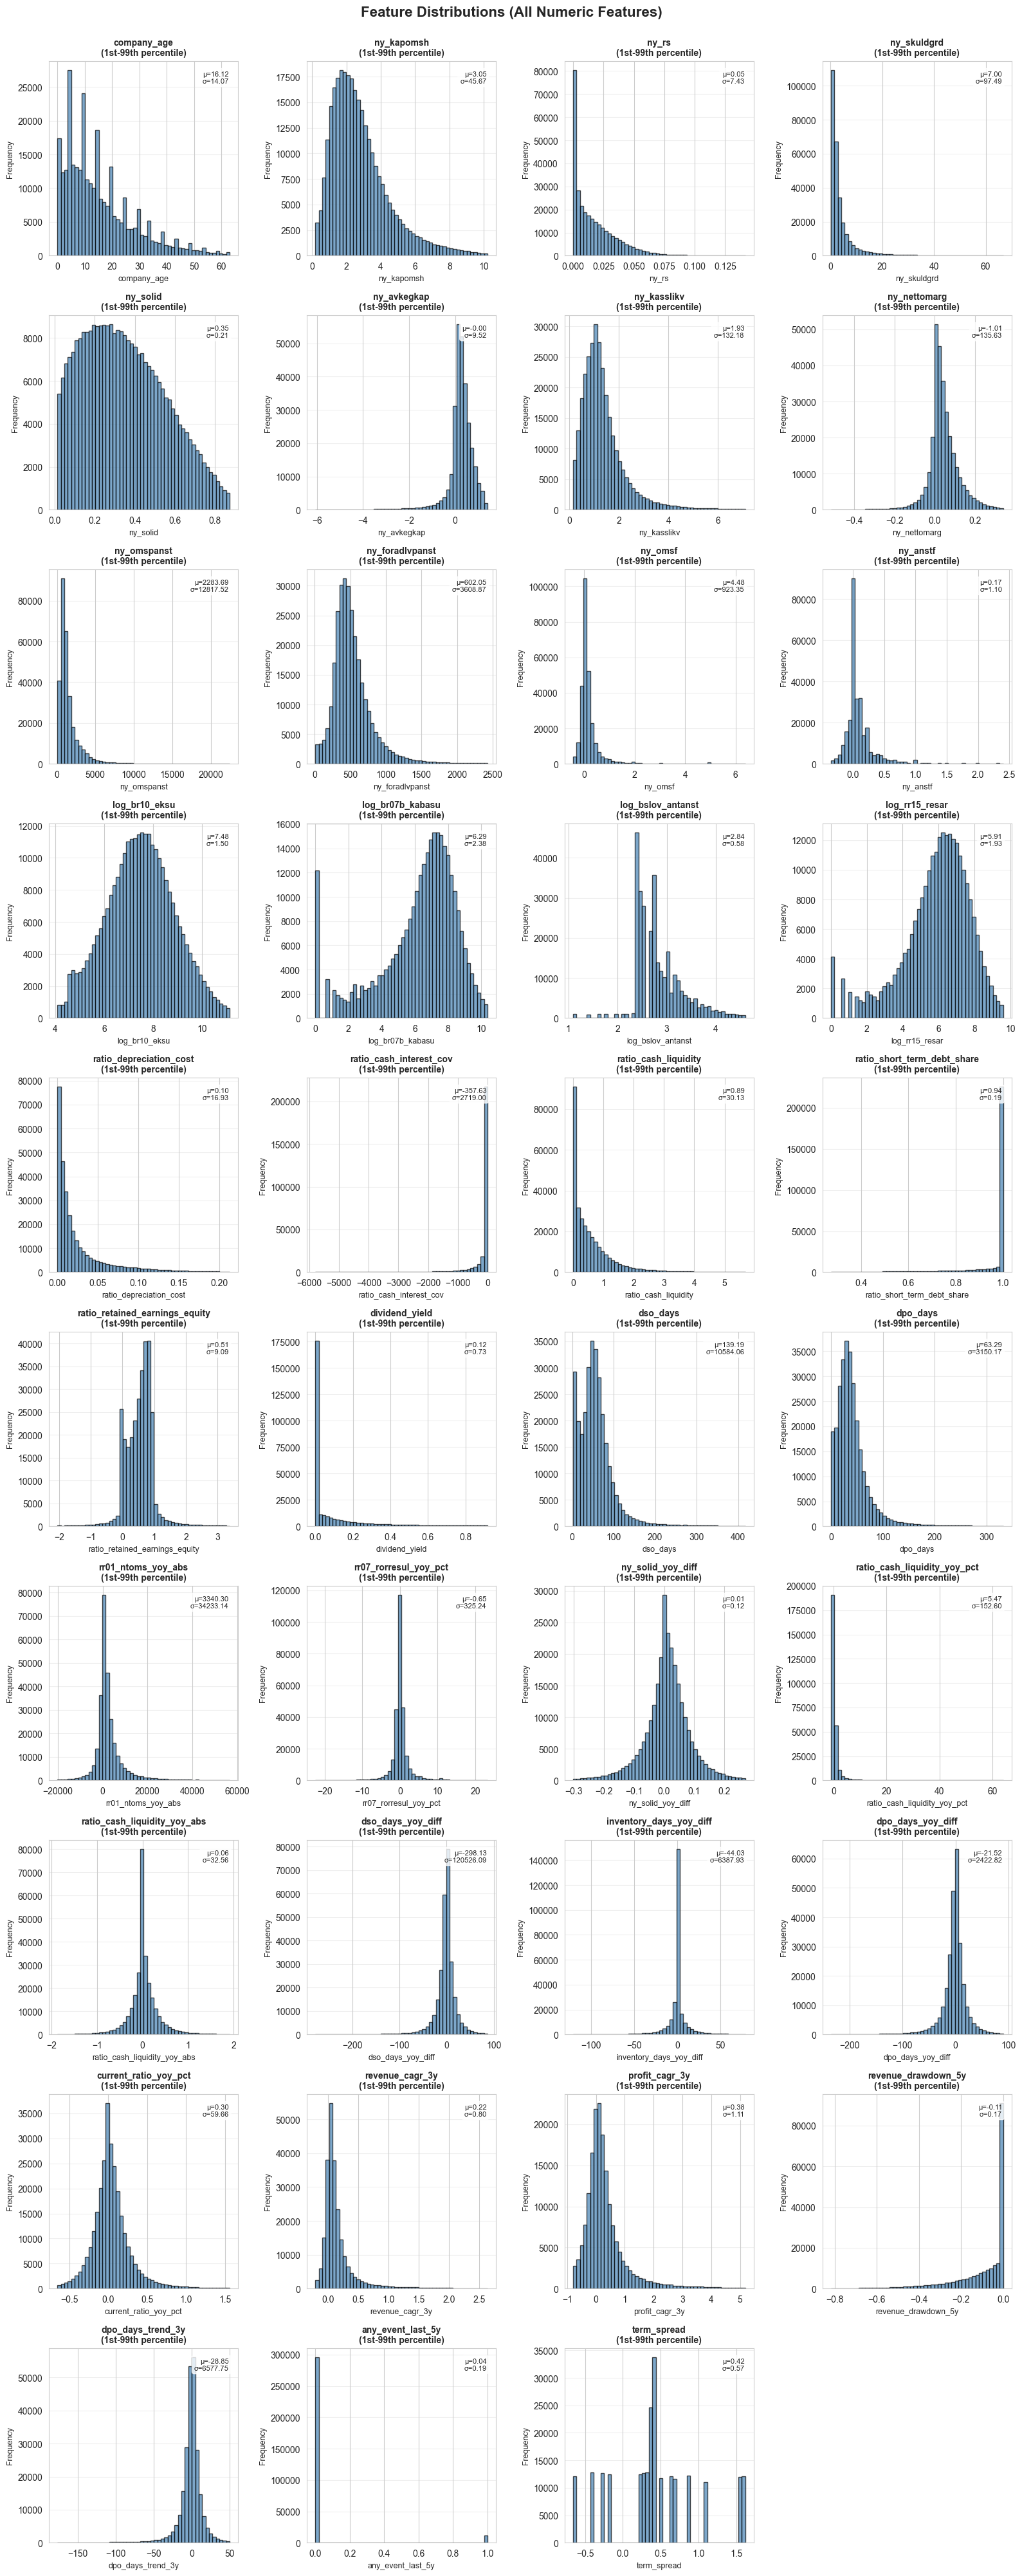

In [ ]:
# Histograms for all numeric features
n_features = len(numeric_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    ax = axes[idx]
    
    # Remove extreme outliers for visualization (1st-99th percentile)
    data = X[feature].dropna()
    if len(data) > 0:
        p1, p99 = data.quantile([0.01, 0.99])
        data_clipped = data[(data >= p1) & (data <= p99)]
        
        ax.hist(data_clipped, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xlabel(feature, fontsize=9)
        ax.set_ylabel('Frequency', fontsize=9)
        ax.set_title(f'{feature}\n(1st-99th percentile)', fontsize=10, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Add summary stats
        stats_text = f"μ={data.mean():.2f}\nσ={data.std():.2f}"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                fontsize=8, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                ha='center', va='center', fontsize=12)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Distributions (All Numeric Features)', 
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

## 4. Feature Correlations

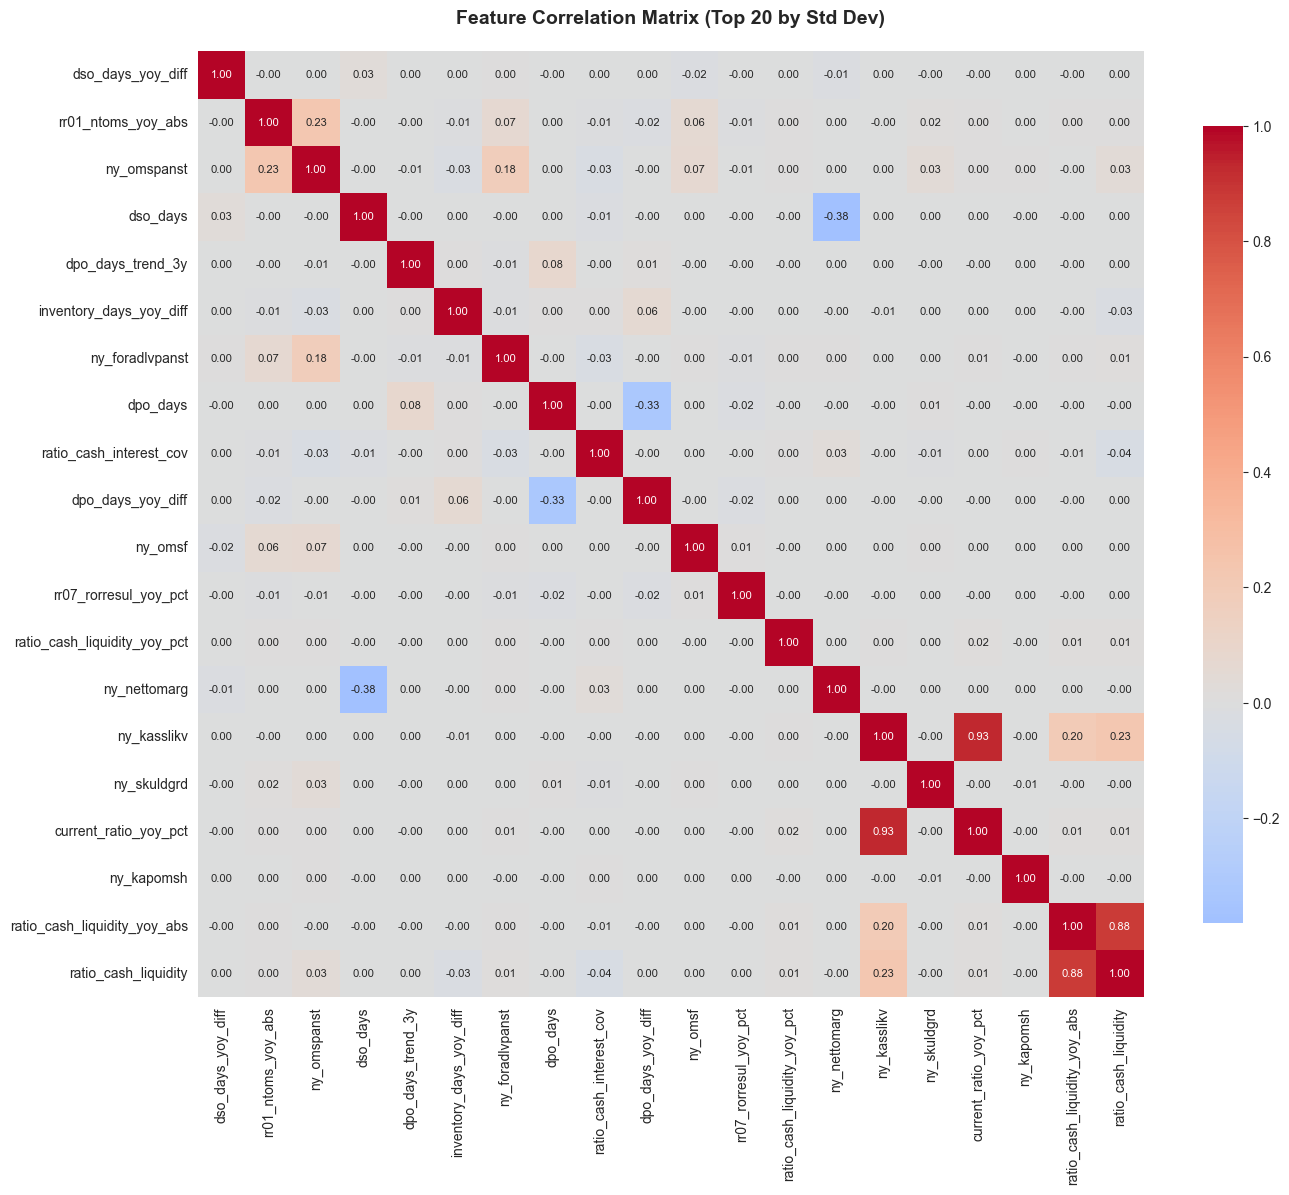


Analyzing correlations across all numeric features...

Highly Correlated Feature Pairs (|r| > 0.7): 2 pairs found
           feature_1                    feature_2  correlation
         ny_kasslikv        current_ratio_yoy_pct     0.929977
ratio_cash_liquidity ratio_cash_liquidity_yoy_abs     0.875941


In [ ]:
# Correlation matrix for all numeric features
# For readability, limit to top 20 most variable features
top_20_features = feature_stats.sort_values('std', ascending=False).head(20).index.tolist()
corr_matrix = X[top_20_features].corr()

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={'shrink': 0.8},
            annot_kws={'fontsize': 8})
ax.set_title('Feature Correlation Matrix (Top 20 by Std Dev)', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated pairs across ALL numeric features
print("\nAnalyzing correlations across all numeric features...")
full_corr_matrix = X[numeric_features].corr()
high_corr = []
for i in range(len(full_corr_matrix.columns)):
    for j in range(i+1, len(full_corr_matrix.columns)):
        if abs(full_corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'feature_1': full_corr_matrix.columns[i],
                'feature_2': full_corr_matrix.columns[j],
                'correlation': full_corr_matrix.iloc[i, j]
            })

if high_corr:
    print(f"\nHighly Correlated Feature Pairs (|r| > 0.7): {len(high_corr)} pairs found")
    print("="*80)
    high_corr_df = pd.DataFrame(high_corr).sort_values('correlation', ascending=False, key=abs)
    print(high_corr_df.to_string(index=False))
else:
    print("\n✓ No highly correlated feature pairs (|r| > 0.7) among all numeric features")

## 5. Company Size Distribution

SME SIZE DISTRIBUTION
sme_category  n_companies  n_defaults  default_rate
       Micro            0           0          <NA>
       Small       290607        6192      0.021307
      Medium        16378         307      0.018745
       Large            0           0          <NA>
     Unknown            0           0          <NA>


/var/folders/5c/7nyvkw450d38pmzqgbgq75wc0000gn/T/ipykernel_75134/3591146831.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sme_dist = df_with_target.groupby('sme_category').agg({


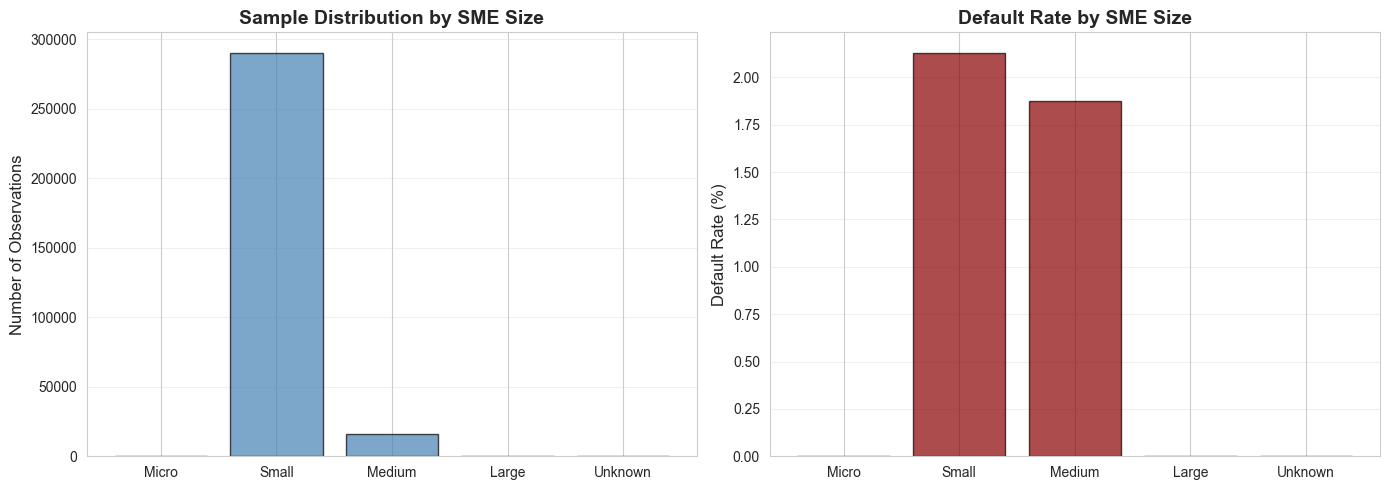

In [ ]:
# SME category distribution
sme_dist = df_with_target.groupby('sme_category').agg({
    'target_next_year': ['count', 'sum', 'mean']
}).reset_index()
sme_dist.columns = ['sme_category', 'n_companies', 'n_defaults', 'default_rate']

print("="*80)
print("SME SIZE DISTRIBUTION")
print("="*80)
print(sme_dist.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sample distribution
axes[0].bar(sme_dist['sme_category'], sme_dist['n_companies'], 
            color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Number of Observations', fontsize=12)
axes[0].set_title('Sample Distribution by SME Size', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Default rate by size - convert to float to handle NA values
default_rate_values = pd.to_numeric(sme_dist['default_rate'], errors='coerce').fillna(0) * 100
axes[1].bar(sme_dist['sme_category'], default_rate_values,
            color='darkred', alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Default Rate (%)', fontsize=12)
axes[1].set_title('Default Rate by SME Size', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Industry Distribution

TOP 10 INDUSTRIES BY SAMPLE SIZE
industry  n_companies  n_defaults  default_rate
     494        19260         439      0.022793
     561        17570         437      0.024872
     471        16131          94      0.005827
     432        15100         341      0.022583
     412        13240         478      0.036103
     433        11796         345      0.029247
     812        10341         208      0.020114
     431         8008         196      0.024476
     439         8000         200         0.025
     711         7923         137      0.017291


/var/folders/5c/7nyvkw450d38pmzqgbgq75wc0000gn/T/ipykernel_75134/2679130628.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  industry_dist = df_with_target.groupby('sni_group_3digit').agg({


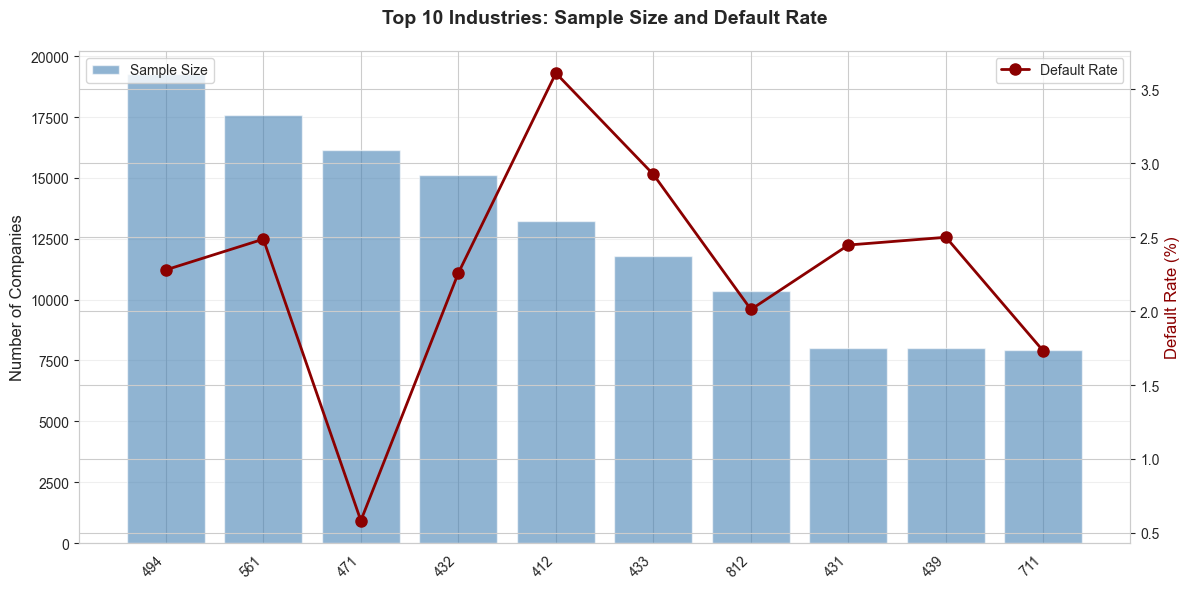

In [ ]:
# Top 10 industries by sample size
if 'sni_group_3digit' in df_with_target.columns:
    industry_dist = df_with_target.groupby('sni_group_3digit').agg({
        'target_next_year': ['count', 'sum', 'mean']
    }).reset_index()
    industry_dist.columns = ['industry', 'n_companies', 'n_defaults', 'default_rate']
    industry_dist = industry_dist.sort_values('n_companies', ascending=False).head(10)
    
    print("="*80)
    print("TOP 10 INDUSTRIES BY SAMPLE SIZE")
    print("="*80)
    print(industry_dist.to_string(index=False))
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Dual axis: sample size (bars) and default rate (line)
    ax2 = ax.twinx()
    
    x_pos = np.arange(len(industry_dist))
    ax.bar(x_pos, industry_dist['n_companies'], 
           color='steelblue', alpha=0.6, label='Sample Size')
    ax2.plot(x_pos, industry_dist['default_rate']*100, 
             color='darkred', marker='o', linewidth=2, markersize=8, label='Default Rate')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(industry_dist['industry'], rotation=45, ha='right')
    ax.set_ylabel('Number of Companies', fontsize=12)
    ax2.set_ylabel('Default Rate (%)', fontsize=12, color='darkred')
    ax.set_title('Top 10 Industries: Sample Size and Default Rate', 
                 fontsize=14, fontweight='bold', pad=20)
    
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Industry information not available in dataset")

## 7. Summary for Thesis Appendix

In [ ]:
# Create comprehensive summary table
summary = {
    'Metric': [
        'Total Observations',
        'Number of Features',
        'Time Period',
        'Default Rate (%)',
        'Imbalance Ratio',
        'Small SMEs (%)',
        'Medium SMEs (%)',
        'Features with Missing Data',
        'Avg Missing Rate (%)'
    ],
    'Value': [
        f"{len(X):,}",
        f"{X.shape[1]}",
        f"{df['ser_year'].min()}-{df['ser_year'].max()}",
        f"{y.mean()*100:.2f}",
        f"{(y==0).sum()/(y==1).sum():.1f}:1",
        f"{(df['sme_category']=='Small').mean()*100:.1f}",
        f"{(df['sme_category']=='Medium').mean()*100:.1f}",
        f"{len(features_with_missing) if len(features_with_missing) > 0 else 0}",
        f"{missing_data['missing_pct'].mean():.2f}" if len(features_with_missing) > 0 else "0.00"
    ]
}

summary_df = pd.DataFrame(summary)

print("\n" + "="*80)
print("DATASET SUMMARY FOR THESIS APPENDIX")
print("="*80)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv(output_dir / "dataset_summary.csv", index=False)
print(f"\n✓ Dataset summary saved to: {output_dir / 'dataset_summary.csv'}")

print("\n" + "="*80)
print("DATA EXPLORATION COMPLETE")
print("="*80)
print(f"\nOutputs saved to: {output_dir}")
print("  - feature_statistics.csv: Full feature summary statistics")
print("  - dataset_summary.csv: High-level dataset summary")
print("\nAll figures in this notebook are suitable for thesis appendix.")

NameError: name 'X' is not defined